In [15]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score
import random
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [2]:
# Pitching dataset without team stats
df = pd.read_csv('batting_pitching_combined.csv', delimiter=',')

In [3]:
# list and drop columns that are less related to the target
cols_to_drop = ['name', 'playerid', 'mlbamid', 'team', 'Acronym', 'Full Name', 'Full Team Name', 'Drafted By', 'Drafted From', 'team_new', 'division', 'team_id', 'team_teamstats', 'Difference']
df = df.drop(columns=cols_to_drop)
print(df.columns.tolist())

# convert the target to numerical values
df['Drafted?'] = df['Drafted?'].astype(int)

['age', 'nameascii', 'year', 'w', 'l', 'era', 'g_pitch', 'gs', 'cg', 'sho', 'sv', 'ip', 'tbf', 'h_pitch', 'r_pitch', 'er', 'hr_pitch', 'bb_pitch', 'hbp_pitch', 'wp', 'bk', 'so_pitch', 'k/9', 'bb/9', 'k/bb', 'hr/9', 'k%_pitch', 'bb%_pitch', 'k-bb%', 'avg_pitch', 'whip', 'babip_pitch', 'lob%', 'fip', 'e-f', 'g_bat', 'ab', 'pa', 'h_bat', '1b', '2b', '3b', 'hr_bat', 'r_bat', 'rbi', 'bb_bat', 'so_bat', 'hbp_bat', 'sf', 'sh', 'gdp', 'sb', 'cs', 'avg_bat', 'bb%_bat', 'k%_bat', 'bb/k', 'obp', 'slg', 'ops', 'iso', 'spd', 'babip_bat', 'wsb', 'wrc', 'wraa', 'woba', 'wrc+', 'role', 'Round', 'Pick', 'Drafted?', 'team_old', 'league', 'W', 'L', 'T', 'G', 'WPCT', 'PE', 'BB (Batting)', 'AB', 'H', 'BA', 'DP', 'DPPG', '2B', '2BPG', 'IP', 'R (Pitching)', 'ER', 'ERA', 'PO', 'A', 'E', 'FPCT', 'HB', 'HBP', 'HA', 'HAPG', 'HR', 'HRPG', 'SF', 'SH', 'OBP', 'SB', 'SBPG', 'CS', 'R (Batting)', 'RPG', 'SHO', 'TB', 'SLG', 'SO', 'BB (Pitching)', 'K/BB', 'K/9', 'TP', '3B', '3BPG', 'WHIP', 'BBPG (Pitching)']


In [5]:
df.head(10)

,age,nameascii,year,w,l,era,g_pitch,gs,cg,sho,...,SLG,SO,BB (Pitching),K/BB,K/9,TP,3B,3BPG,WHIP,BBPG (Pitching)
0,19.0,A.J. Causey,2022,4.0,4.0,2.606897,25.0,1.0,0.0,0.0,...,0.432,450.0,245.0,1.84,8.3,NaN,10.0,0.18,1.59,4.52
1,20.0,A.J. Causey,2023,5.0,2.0,5.069869,15.0,14.0,1.0,0.0,...,0.482,474.0,257.0,1.84,8.8,NaN,13.0,0.23,1.60,4.78
2,21.0,A.J. Causey,2024,13.0,3.0,4.434306,19.0,6.0,0.0,0.0,...,0.607,700.0,210.0,3.33,10.1,1.0,9.0,0.12,1.25,3.04
3,20.0,A.J. Colarusso,2024,3.0,8.0,7.200000,14.0,14.0,0.0,0.0,...,0.423,409.0,241.0,1.70,8.0,NaN,9.0,0.17,1.70,4.73
4,21.0,A.J. Colarusso,2025,1.0,6.0,4.886878,19.0,15.0,0.0,0.0,...,0.379,428.0,231.0,1.85,7.8,NaN,9.0,0.16,1.60,4.21
5,19.0,A.J. Evasco,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.439,519.0,274.0,1.89,9.4,NaN,11.0,0.19,1.55,4.97
6,NaN,A.J. Martin,2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.483,393.0,258.0,1.52,7.7,NaN,13.0,0.25,1.71,5.04
7,19.0,A.J. Mendolia,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.365,272.0,208.0,1.31,5.6,NaN,16.0,0.31,1.84,NaN
8,20.0,A.J. Mendolia,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.296,310.0,266.0,1.17,6.3,NaN,9.0,0.17,1.91,5.38
9,21.0,A.J. Mendolia,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.340,315.0,256.0,1.23,6.3,NaN,14.0,0.27,1.83,5.15


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17118 entries, 0 to 17117
Columns: 122 entries, age to BBPG (Pitching)
dtypes: float64(116), int64(2), object(4)
memory usage: 15.9+ MB


In [7]:
player_features = list(df[['age', 'w', 'l', 'era', 'g_pitch', 'gs', 'cg', 'sho', 'sv', 'ip', 'tbf', 
                           'h_pitch', 'r_pitch', 'er', 'hr_pitch', 'bb_pitch', 'hbp_pitch', 'wp', 
                           'bk', 'so_pitch', 'k/9', 'bb/9', 'k/bb', 'hr/9', 'k%_pitch', 'bb%_pitch', 
                           'k-bb%', 'avg_pitch', 'whip', 'babip_pitch', 'lob%', 'fip', 'e-f', 'g_bat', 
                           'ab', 'pa', 'h_bat', '1b', '2b', '3b', 'hr_bat', 'r_bat', 'rbi', 'bb_bat', 
                           'so_bat', 'hbp_bat', 'sf', 'sh', 'gdp', 'sb', 'cs', 'avg_bat', 'bb%_bat', 
                           'k%_bat', 'bb/k', 'obp', 'slg', 'ops', 'iso', 'spd', 'babip_bat', 'wsb', 
                           'wrc', 'wraa', 'woba', 'wrc+']].columns)

team_features = list(df[['W', 'L', 'T', 'G', 'WPCT', 'PE', 'BB (Batting)', 'AB', 'H', 'BA', 'DP', 
                    'DPPG', '2B', '2BPG', 'IP', 'R (Pitching)', 'ER', 'ERA', 'PO', 'A', 'E', 
                    'FPCT', 'HB', 'HBP', 'HA', 'HAPG', 'HR', 'HRPG', 'SF', 'SH', 'OBP', 
                    'SB', 'SBPG', 'CS', 'R (Batting)', 'RPG', 'SHO', 'TB', 'SLG', 'SO', 'BB (Pitching)', 
                    'K/BB', 'K/9', 'TP', '3B', '3BPG', 'WHIP', 'BBPG (Pitching)']].columns)

redundant_features = ['k%', 'bb%', 'K/BB', 'k/bb']
lasso_selected_features = [
    'age', 'fip', 'K/9', 'WHIP', 'so', 'g', 'L', 'hr/9', 'wp', 'l', 'ER',
    'HRPG', 'SF', 'babip', 'SHO', 'A', 'bk', 'BB (Pitching)', 'PE', '3B',
    'ip', 'FPCT', 'CS', 'w', 'HB', 'DPPG', 'SH', 'T', 'SO', 'BBPG (Pitching)',
    'SBPG', 'cg', 'RPG', 'k-bb%', 'HBP', '2BPG', 'sho', 'e-f', 'lob%', 'sv', 'E'
]
lasso_selected_features = [f for f in lasso_selected_features if f not in redundant_features]
features = player_features + team_features
#features = lasso_selected_features

df = pd.get_dummies(df, columns=['league'], drop_first=True)
df = pd.get_dummies(df, columns=['team_old'], drop_first=True)

X = df[features]
y = df['Drafted?'].astype(int)

In [8]:
# Separate the two classes
drafted_indices = df[df['Drafted?'] == 1].index
not_drafted_indices = df[df['Drafted?'] == 0].index

print(f"Original class distribution:")
print(f"  Class 0 (Not Drafted): {len(not_drafted_indices)}")
print(f"  Class 1 (Drafted): {len(drafted_indices)}")

# Randomly sample from class 0 to match class 1 size
np.random.seed(42)  # for reproducibility
undersampled_not_drafted = np.random.choice(not_drafted_indices, size=len(drafted_indices), replace=False)

# Combine the balanced indices
balanced_indices = np.concatenate([drafted_indices, undersampled_not_drafted])
np.random.shuffle(balanced_indices)

# Create balanced dataset
X_balanced = X.loc[balanced_indices]
y_balanced = y.loc[balanced_indices]

print(f"\nBalanced class distribution:")
print(f"  Class 0 (Not Drafted): {sum(y_balanced == 0)}")
print(f"  Class 1 (Drafted): {sum(y_balanced == 1)}")
print(f"  Total samples: {len(y_balanced)}")
print(f"  Class 1 percentage: {sum(y_balanced == 1) / len(y_balanced) * 100:.1f}%")

Original class distribution:
  Class 0 (Not Drafted): 15676
  Class 1 (Drafted): 1442

Balanced class distribution:
  Class 0 (Not Drafted): 1442
  Class 1 (Drafted): 1442
  Total samples: 2884
  Class 1 percentage: 50.0%


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

In [10]:
neg_count = sum(y_train == 0)
pos_count = sum(y_train == 1)
scale_pos_weight = neg_count / pos_count

print(f"\nTraining set distribution:")
print(f"  Class 0: {neg_count}")
print(f"  Class 1: {pos_count}")
print(f"  Scale_pos_weight: {scale_pos_weight:.2f}")


Training set distribution:
  Class 0: 1153
  Class 1: 1154
  Scale_pos_weight: 1.00


In [11]:
draft_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

draft_model.fit(X_train, y_train)

y_pred = draft_model.predict(X_test)
y_proba = draft_model.predict_proba(X_test)[:,1]

print("\nDrafted? Classifier Results (Balanced Dataset):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")
print(classification_report(y_test, y_pred, digits=3))


Drafted? Classifier Results (Balanced Dataset):
Accuracy: 0.870

              precision    recall  f1-score   support

           0      0.896     0.837     0.866       289
           1      0.847     0.903     0.874       288

    accuracy                          0.870       577
   macro avg      0.872     0.870     0.870       577
weighted avg      0.872     0.870     0.870       577



In [12]:
importance = draft_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 Features by Importance:")
print(importance_df.head(20))


Top 20 Features by Importance:
      Feature  Importance
0         age   20.384447
61        wrc   16.097015
35      h_bat    9.457603
18   so_pitch    7.224361
104        SO    5.405807
67          T    5.056159
55        slg    4.777854
56        ops    3.809532
23   k%_pitch    3.621103
40      r_bat    3.220612
107       K/9    2.792188
90       HAPG    2.775967
50    avg_bat    2.649649
30        fip    2.612353
86       FPCT    2.546406
57        iso    2.440005
25      k-bb%    2.426104
91         HR    2.239397
41        rbi    2.081878
85          E    2.062499


In [13]:
target_drafted = 'Drafted?'
target_pick = 'Pick'

drafted_df = df[df[target_drafted] == 1]
X_drafted = drafted_df[features]
y_pick = drafted_df[target_pick]

X_train_pick, X_test_pick, y_train_pick, y_test_pick = train_test_split(
    X_drafted, y_pick, test_size=0.2, random_state=42
)

pick_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.7,
    random_state=42
)

pick_model.fit(X_train_pick, y_train_pick)

pick_preds = pick_model.predict(X_test_pick)

print("\nPick Prediction:")
print(f"MAE: {mean_absolute_error(y_test_pick, pick_preds):.3f}")

corr, _ = spearmanr(y_test_pick, pick_preds)
print(f"Spearman correlation: {corr:.3f}")


Pick Prediction:
MAE: 108.287
Spearman correlation: 0.595


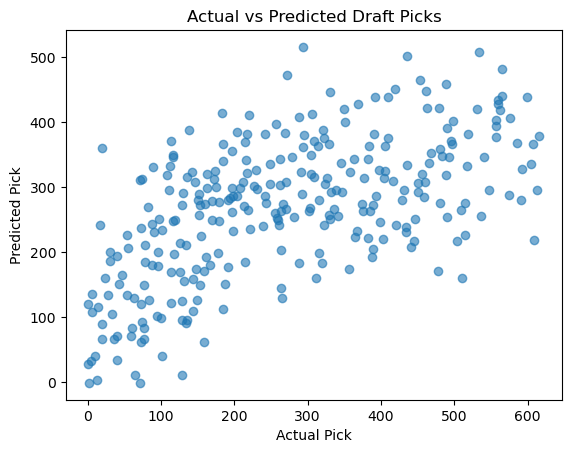

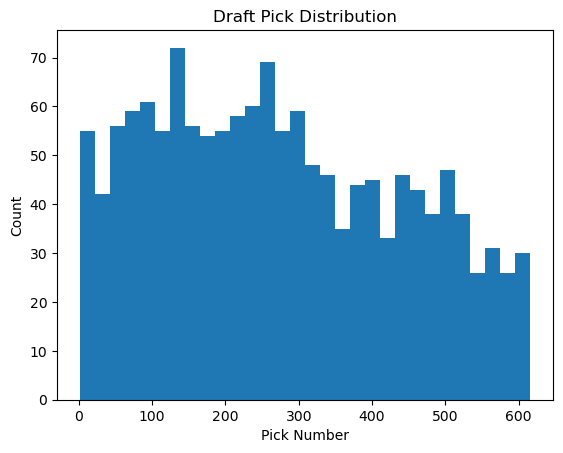

In [16]:
plt.scatter(y_test_pick, pick_preds, alpha=0.6)
plt.xlabel("Actual Pick")
plt.ylabel("Predicted Pick")
plt.title("Actual vs Predicted Draft Picks")
plt.show()

import matplotlib.pyplot as plt
plt.hist(y_pick, bins=30)
plt.xlabel("Pick Number")
plt.ylabel("Count")
plt.title("Draft Pick Distribution")
plt.show()

In [20]:
missing_summary = X.isnull().mean().sort_values(ascending=False)
print(missing_summary[missing_summary > 0].head(100))

TP              0.980780
w               0.670405
bk              0.670405
so_pitch        0.670405
k/9             0.670405
                  ...   
BB (Batting)    0.022783
AB              0.022783
H               0.022783
BA              0.022783
DP              0.022783
Length: 100, dtype: float64
